# A ~~Quick~~ Survey and Comparison of Open Source Named Entity Extractor Tools for Python

Named entity extraction is a core subtask of building knowledge from semi/unstructured text sources<sup><a href="#fn1" id="ref1">1</a></sup>.  Considering recent increases in computing power and decreases in the costs of data storage, data scientists and developers can build large knowledge bases that contain millions of entities and hundreds of millions of facts about them.  These knowledge bases are key contributors to intelligence computer behavior<sup><a href="#fn2" id="ref2">2</a></sup>.  Therefore, named entity extraction is at the core of several popular technologies such as smart assistants ([Siri](http://www.apple.com/ios/siri/), [Google Now](https://www.google.com/landing/now/)), machine reading, and deep interpretation of natural language<sup><a href="#fn3" id="ref3">3</a></sup>.

With a realization of how essential it is to recognize information units like names, including person, organization and location names, and numeric expressions including time, date, money
and percent expressions, several questions come to mind.  How do you perform named entity extraction, which is formally called “[Named Entity Recognition and Classification (NERC)](https://benjamins.com/catalog/bct.19)”?  What tools are out there?  How can you evaluate their performance?  And most important, what works with Python (shamelessly exposing my bias)?  

This post will survey openly available NERC tools and compare the results against hand labeled data for precision, accuracy, and recall.  The tools and basic information extraction principles in this discussion begin the process of structuring unstructured data.

We will specifically learn to:
1. follow the data science pipeline (see image below)
2. prepare semistructured natural language data for ingest using regex
3. create a custom corpus in [Natural Language Toolkit](http://www.nltk.org/) 
4. use a suite of openly available NERC tools to extract entities and store in json format 
5. compare the performance of NERC tools on our corpus

<br>
<a href="#pipe" id="pipeline"><center><h3>The Data Science Pipeline:<br>Georgetown Data Science Certificate Program</h3></center></a>
<div class="image">

      <img src="./files/data_science_pipeline.png" alt="Data Science Pipeline" height="300" width="450" top:"35" left:"170" />
      
      

</div>



### The Data: Peer Reviewed Journals and Keynote Speaker Abstracts from KDD 2014 and 2015

Before delving into the pipeline, we need a good dataset.  Jason Brownlee of www.machinelearningmastery.com had some good suggestions in his [August 2015 article](http://machinelearningmastery.com/practice-machine-learning-with-small-in-memory-datasets-from-the-uci-machine-learning-repository/) on picking a dataset for machine learning exercises:  

* **Real-World**: The datasets should be drawn from the real world (rather than being contrived). This will keep them interesting and introduce the challenges that come with real data.

* **Small**: The datasets need to be small so that you can inspect and understand them and that you can run many models quickly to accelerate your learning cycle.

* **Well-Understood**: There should be a clear idea of what the data contains, why it was collected, what the problem is that needs to be solved so that you can frame your investigation.

* **Baseline**: It is also important to have an idea of what algorithms are known to perform well and the scores they achieved so that you have a useful point of comparison. This is important when you are getting started and learning because you need quick feedback as to how well you are performing (close to state-of-the-art or something is broken).

* **Plentiful**: You need many datasets to choose from, both to satisfy the traits you would like to investigate and (if possible) your natural curiosity and interests. 

Luckily, we have a dataset that meets nearly all of these requirements.  I attended the Knowledge Discovery and Data Mining (KDD) conferences in [New York City (2014)](http://www.kdd.org/kdd2014/) and [Sydney, Australia (2015)](http://www.kdd.org/kdd2015/).  Both years, attendees received a USB with the conference proceedings.  Each repository contains over 230 peer reviewed journal articles and keynote speaker abstracts on data mining, knowledge discovery, big data, data science and their applications. The full conference proceedings can be purchased for \$60 at the [Association for Computing Machinery's Digital Library](https://dl.acm.org/purchase.cfm?id=2783258&CFID=740512201&CFTOKEN=34489585) (includes ACM membership). This post will work with a dataset that is equivalent to the conference proceedings.  It's important to note that this dataset recreates a real word data science exercise that is instructive of big data problems.  We will take semi-structured data (PDF journal articles and abstracts in publication format), strip text from the files, and add more structure to the data that would facilitate follow on analysis. 

<blockquote cite="https://github.com/linwoodc3/LC3-Creations/blob/master/DDL/namedentityblog/KDDwebscrape.ipynb">
Interested parties looking for a free option can use the <a href="https://pypi.python.org/pypi/beautifulsoup4/4.4.1">beautifulsoup</a> and <a href="https://pypi.python.org/pypi/requests/2.9.1">request</a> libraries to scrape the <a href="http://dl.acm.org/citation.cfm?id=2785464&CFID=740512201&CFTOKEN=3448958">ACM website for KDD 2015 conference data</a> that can be used in natural language processing pipelines.  I have some <a href="https://github.com/linwoodc3/LC3-Creations/blob/master/DDL/namedentityblog/KDDwebscrape.ipynb">skeleton web scraping code</a> to generate lists of all abstracts, author names, and journal/keynote address titles.    
</blockquote>


### Data Exploration: Getting the number of files, and file type 

The data is stored locally in the following directory:
```python
>>> import os
>>> print os.getcwd()
/Users/linwood/Desktop/KDD_15/docs
```
Let's explore the number of files we have and naming conventions. We begin with the administrative tasks of loading modules, establishing paths, etc.  
<br><br>

In [1]:
#**********************************************************************
# Importing what we need
#**********************************************************************
import os
import time
from os import walk

#**********************************************************************
# Administrative code to set the path for file loading
#**********************************************************************

path        = os.path.abspath(os.getcwd())
TESTDIR     = os.path.normpath(os.path.join(os.path.expanduser("~"),"Desktop","KDD_15","docs"))

<br><br>Next we iterate over the files in the directory and store those names in the empty list we created called *files*.  We time the operation, print list with the file names and also print out the length of the list (gives number of target files).<br><br>

In [4]:
# Establish an empty list to append filenames as we iterate over the directory with filenames
files = []

%time
start_time = time.time()

#**********************************************************************
# Core "workerbee" code for this section to iterate over directory files
#**********************************************************************

# Iterate over the directory of filenames and add to list.  Inspection shows our target filenames begin with 'p' and end with 'pdf'
for dirName, subdirList, fileList in os.walk(TESTDIR):
    for fileName in fileList:
        if fileName.startswith('p') and fileName.endswith('.pdf'):
            files.append(fileName)
end_time = time.time()

#**********************************************************************
# Output
#**********************************************************************
print
print len(files) # Print the number of files
print 
print '[%s]' % ', '.join(map(str, files)) # print the list of filenames

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs

253

[p1.pdf, p1005.pdf, p1015.pdf, p1025.pdf, p1035.pdf, p1045.pdf, p1055.pdf, p1065.pdf, p1075.pdf, p1085.pdf, p109.pdf, p1095.pdf, p1105.pdf, p1115.pdf, p1125.pdf, p1135.pdf, p1145.pdf, p1155.pdf, p1165.pdf, p1175.pdf, p1185.pdf, p119.pdf, p1195.pdf, p1205.pdf, p1215.pdf, p1225.pdf, p1235.pdf, p1245.pdf, p1255.pdf, p1265.pdf, p1275.pdf, p1285.pdf, p129.pdf, p1295.pdf, p1305.pdf, p1315.pdf, p1325.pdf, p1335.pdf, p1345.pdf, p1355.pdf, p1365.pdf, p1375.pdf, p1385.pdf, p139.pdf, p1395.pdf, p1405.pdf, p1415.pdf, p1425.pdf, p1435.pdf, p1445.pdf, p1455.pdf, p1465.pdf, p1475.pdf, p1485.pdf, p149.pdf, p1495.pdf, p1503.pdf, p1513.pdf, p1523.pdf, p1533.pdf, p1543.pdf, p1553.pdf, p1563.pdf, p1573.pdf, p1583.pdf, p159.pdf, p1593.pdf, p1603.pdf, p1621.pdf, p1623.pdf, p1625.pdf, p1627.pdf, p1629.pdf, p1631.pdf, p1633.pdf, p1635.pdf, p1637.pdf, p1639.pdf, p1641.pdf, p1651.pdf, p1661.pdf, p1671.pdf, p1681.pdf, p169.pdf, p1691.pdf, p170

<br><br>There are 253 total files in the directory. We examine the pdf file in its rawest form to get an idea of the format. Here is one example:<br><br>



<img src="./files/journalscreencap.png" alt="Sample of Journal Format" height="700" width="700" top:"35" left:"170">


<br><br>We learn a few things immediately. Our data is in PDF format and it's semistructured (follows journal article format with sections like "abstract", "title").  PDFs are a wonderful human readable presentation of data. But for data analyisis, they are extremely difficult to work with.  If you have an option to get the data BEFORE it was converted to or added to PDF, go for that option.  If it's your only option, be prepared for a lot of these moments:

![Pulling hair out](http://i1012.photobucket.com/albums/af243/njmike731/man-pulling-hair-out-2-773892-1.jpg)

In today's exercise, we have no alternatives outside of the web scraping code linked above.  In full disclosure, that code is imperfect because we get an incomplete dataset.  The abstracts and authors are not matched to the papers and we don't pull in the references section. <br><br>

### Data Ingestion: Stripping text from PDFs and creating a custom NLTK corpus

The first step in the <href id="pipe"><a href="#pipeline" title="Jump back to data science pipeline graphic.">data science pipeline</a> is to ingest our data.  We use several Python tools which include:

* [pdfminer](https://pypi.python.org/pypi/pdfminer/) - this is the tool that makes it ALL happen.  It has a command line tool called "pdf2text.py" that extract text contents from a PDF. **This must be installed on your computer BEFORE executing this code**.  Visit the [pdfminer homepage](http://euske.github.io/pdfminer/index.html#pdf2txt) for instructions

* [subprocess](https://docs.python.org/2/library/subprocess.html) - a standard library module that allows you to spawn new processes, connect to their input/output/error pipes, and obtain their return codes.  In this excerise, we use it to invoke the pdf2texy.py command line tool within our code.  

* [nltk](http://www.nltk.org/) - another work horse in this exercise.  The Natural Language ToolKit (NLTK) is one of Python's leading platforms to analyze natural language data.  The [NLTK Book](http://www.nltk.org/book/) provides practical guidance on how to handle just about any natural language preprocessing job.  

* [string](https://docs.python.org/2/library/string.html) - used for variable substitutions and value formatting to strip non printable characters from the output of the text extracted from our journal article PDFs

* [unicodedata](https://docs.python.org/2/library/unicodedata.html) - some unicode characters won't extract nicely. This library allows latin unicode characters to degrade gracefully into ASCII.

We are now going to iterate over each file in our raw data directory, strip the text, and write the *.txt* file to newly created directory.  Then we will follow the instructions from [Section 1.9, Chapter 2 of NLTK's Book](http://www.nltk.org/book/ch02.html) to build a custom corpus from our text files.  Having our target documents loaded as an NLTK corpus brings the power of NLTK to our analysis goals.  Let's begin with administrative tasks such as loading modules and creating the necessary directories.<br><br>

In [2]:
#**********************************************************************
# Importing what we need
#**********************************************************************
import string
import unicodedata
import subprocess
import nltk
import os, os.path
import re

#**********************************************************************
# Create the directory we will write the .txt files to after stripping text
#**********************************************************************

corpuspath = os.path.normpath(os.path.expanduser('~/Desktop/KDD_corpus/'))
if not os.path.exists(corpuspath):
    os.mkdir(corpuspath)

<br><br>Now we are to the big task of stripping text from the PDFs.  In the code below, we walk down the directory, and strip text from the files with names that begin with 'p' and end with 'pdf'.  We use the *fileName* variable to name the files we write to disk.  This will come in handy when we load data into NLTK.  Keep in mind, this task takes the longest, so be prepared to wait a a few minutes depending on good your computer is.  If you are doing this in an environment where you can spin up compute resources, your time will be drastically reduced.  Let's begin.<br><br>

In [10]:
#**********************************************************************
# Core code to iterate over files in the directory
#**********************************************************************

# We start from the code to iterate over the files
%timeit
for dirName, subdirList, fileList in os.walk(TESTDIR):
    for fileName in fileList:
        if fileName.startswith('p') and fileName.endswith('.pdf'):
            if os.path.exists(os.path.normpath(os.path.join(corpuspath,fileName.split(".")[0]+".txt"))):
                pass
            else:
            
            
#**********************************************************************
# This code strips the text from the PDFs
#**********************************************************************
                try:
                    document = filter(lambda x: x in string.printable,unicodedata.normalize('NFKD', (unicode(subprocess.check_output(['pdf2txt.py',str(os.path.normpath(os.path.join(TESTDIR,fileName)))]),errors='ignore'))).encode('ascii','ignore').decode('unicode_escape').encode('ascii','ignore'))
                except UnicodeDecodeError:
                    document = unicodedata.normalize('NFKD', unicode(subprocess.check_output(['pdf2txt.py',str(os.path.normpath(os.path.join(TESTDIR,fileName)))]),errors='ignore')).encode('ascii','ignore')    

                if len(document)<300:
                    pass
                else:
                    # used this for assistance http://stackoverflow.com/questions/2967194/open-in-python-does-not-create-a-file-if-it-doesnt-exist
                    if not os.path.exists(os.path.normpath(os.path.join(corpuspath,fileName.split(".")[0]+".txt"))):
                        file = open(os.path.normpath(os.path.join(corpuspath,fileName.split(".")[0]+".txt")), 'w+')
                        file.write(document)
                    else:
                        pass

kddcorpus= nltk.corpus.PlaintextCorpusReader(corpuspath, '.*\.txt')

In [3]:
kddcorpus= nltk.corpus.PlaintextCorpusReader(corpuspath, '.*\.txt')

<br><br>This is a pretty big step.  We have a semi-structured data set in a format where we can query and analyze different pieces of data.  All of our data is loaded as an NLTK corpus, meaning we could try tons of techniques outlined in the [NLTK book](http://www.nltk.org/book/) or use the NLTK APIs to pass data into [scikit-learn machine learning pipelines for text](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) (maybe for a later blog). Let's see how many words (including stop words) we have in our entire corpus.  <br><br>

In [12]:
wordcount = 0
for fileid in kddcorpus.fileids():
    wordcount += len(kddcorpus.words(fileid))
print wordcount


2795267


This step didn't come off without it's errors.  We got a little bit of gobbledygook (that is a [real word](http://www.merriam-webster.com/dictionary/gobbledygook) by the way). Here are the first 1000 characters of document 2157:

In [284]:
print kddcorpus.raw("p2157.txt")[:1000]

)UDX'HWHFWRU$*UDSK0LQLQJEDVHG)UDPHZRUN

IRU)UDXGXOHQW3KRQH&DOO'HWHFWLRQ

-RVK-LD&KLQJ<LQJ&KH:HL+XDQJ<LPLQ.DRDQG.XDQ7D&KHQ

'HSDUWPHQWRI&RPSXWHU6FLHQFH1DWLRQDO&KLDR7XQJ8QLYHUVLW\7DLZDQ52&

'HSDUWPHQWRI&RPSXWHU6FLHQFHDQG,QIRUPDWLRQ(QJLQHHULQJ1DWLRQDO&KHQJ.XQJ8QLYHUVLW\7DLZDQ52&

*RJRORRN&R/WG7DLZDQ52&

,QVWLWXWHRI,QIRUPDWLRQ6FLHQFH$FDGHPLD6LQLFD7DLZDQ52&

MDVK\LQJ#JPDLOFRPZHLLER\#LGEFVLHQFNXHGXWZ\LPLQNDR#JRJRORRNFRPVZF#LLVVLQLFDHGXWZ

&RUUHVSRQGHQFH YWVHQJ#FVQFWXHGXWZ

$%675$&7
,QUHFHQW\HDUVIUDXGLVLQFUHDVLQJUDSLGO\ZLWKWKHGHYHORSPHQWRI
PRGHUQ WHFKQRORJ\ DQG JOREDO FRPPXQLFDWLRQ $OWKRXJK PDQ\
OLWHUDWXUHV KDYH DGGUHVVHG WKH IUDXG GHWHFWLRQ SUREOHP WKHVH
H[LVWLQJ ZRUNV IRFXV RQO\ RQ IRUPXODWLQJ WKH IUDXG GHWHFWLRQ
SUREOHP DV D ELQDU\ FODVVLILFDWLRQ SUREOHP 'XH WR OLPLWDWLRQ RI
LQIRUPDWLRQSURYLGHGE\WHOHFRPPXQL


<br>The NLTK book has an [excellent section on processing raw text and unicode issues](http://www.nltk.org/book/ch03.html#fig-unicode). I could never figure out what caused the error above but that's a dose of real world data problems.   Let's move on.  To begin our exploration of regular expressions (aka "regex"), it's important to point out some good resources to brush up on the topic.  The best resource I ever had was in [Videos 1-3, Week 4, Getting and Cleaning Data, Data Science Specialization Track](https://www.coursera.org/learn/data-cleaning) (At Coursera by Johns Hopkins University).  The instruction and examples in these helped me UNDERSTAND how to use regex vice googling ["how to match text between two strings python regex"](https://www.google.com/webhp?sourceid=chrome-instant&ion=1&espv=2&ie=UTF-8#q=how+to+match+text+between+two+strings+python+regex) and hacking away until getting the desired output.  When you understand regex, you will start to use metacharacter expression matches vice using literal matches, and crush any text matching requirment.  Here are some learning resources listed in my own subjective order of usefulness and relevance to python:
* http://regexone.com/ (interactive teaching)
* https://regex101.com/ (interactive testing; you can paste your text and test expressions)
* http://regexr.com/ (interactive testing like above)
* http://www.learnpython.org/en/Regular_Expressions (not very intuitive at first glimpse, but useful)
* https://docs.python.org/2/library/re.html (default Python library documentation on regex)

<br>As a quick test, we extract some "good enough" titles from the first 26 documents. I say "good enough" because some author names get caught up int he extractions below.  <br><br>

In [802]:
# This title extraction is probably unnecessarily complex, but it gets the job done; we make use of the metacharacters vice literal matches

p=re.compile('^(.*)([\s]){2}[A-z]+[\s]+[\s]?.+')# matches text, starting from beginning of line, followed by at least two
for fileid in kddcorpus.fileids()[:25]:
    print re.search('^(.*)[\s]+[\s]?(.*)?',kddcorpus.raw(fileid)).group(1).strip()+" "+re.search('^(.*)[\s]+[\s]?(.*)?',kddcorpus.raw(fileid)).group(2).strip()
      # use .strip() to remove whitespace from beginning and end of string

Online Controlled Experiments: Lessons from Running A/B/n Tests for 12 Years
Mining Frequent Itemsets through Progressive Sampling with Rademacher Averages
Why It Happened: Identifying and Modeling the Reasons of the Happening of Social Events
Matrix Completion with Queries Natali Ruchansky
Stochastic Divergence Minimization for Online Collapsed Variational Bayes Zero Inference
Bayesian Poisson Tensor Factorization for Inferring Multilateral Relations from Sparse Dyadic Event Counts
TimeCrunch: Interpretable Dynamic Graph Summarization Neil Shah
Inside Jokes: Identifying Humorous Cartoon Captions Dafna Shahaf
Community Detection based on Distance Dynamics Junming Shao
Discovery of Meaningful Rules in Time Series Mohammad Shokoohi-Yekta    Yanping Chen    Bilson Campana    Bing Hu
On the Formation of Circles in Co-authorship Networks Tanmoy Chakraborty1, Sikhar Patranabis2, Pawan Goyal3, Animesh Mukherjee4
An Evaluation of Parallel Eccentricity Estimation Algorithms on Undirected Real-W

### Data wrangling and computation: Using Regular Expressions to extract specific sections of the paper

We are close to the NERC portion.  But, there's a bit more wrangling to do (remember, PDFs are tough work).  For simplicity, let's focus the NERC on two sections of the paper:
* the top section which includes authors and schools
* the references section of the paper (keynote speaker abstracts do not have an abstract)

The tools of choice to extract sections are the ["positive lookbehind" and "positive lookahead"](https://docs.python.org/2/library/re.html) expressions. Here is an example of code to extract the abstract only:<br>

In [15]:
# set our regular expression
p= re.compile('(?<=ABSTRACT)(.+)(?=Categories and Subject Descriptors)')
try:
    abstract= p.search(re.sub('[\s]'," ",kddcorpus.raw('p1035.txt'))).group(1)
except AttributeError:
    # include a lowercase regex match incase consistency is a problem
    p=re.compile('(?<=abstract)(.+)(?=categories and subject descriptors)')
    abstract=p.search(re.sub('[\s]'," ",holder.lower())).group(1)
else:
    pass
unicodedata.normalize('NFKD', abstract).encode('ascii','ignore').strip() # convert output from unicode to string and strip leading and trailing whitespace

'The collapsed variational Bayes zero (CVB0) inference is a vari- ational inference improved by marginalizing out parameters, the same as with the collapsed Gibbs sampler. A drawback of the CVB0 inference is the memory requirements. A probability vec- tor must be maintained for latent topics for every token in a corpus. When the total number of tokens is N and the number of topics is K, the CVB0 inference requires O(N K) memory. A stochas- tic approximation of the CVB0 (SCVB0) inference can reduce O(N K) to O(V K), where V denotes the vocabulary size. We re- formulate the existing SCVB0 inference by using the stochastic di- vergence minimization algorithm, with which convergence can be analyzed in terms of Martingale convergence theory. We also reveal the property of the CVB0 inference in terms of the leave-one-out perplexity, which leads to the estimation algorithm of the Dirichlet distribution parameters. The predictive performance of the propose SCVB0 inference is better than that o

Nice!  Now, to be "pythonic" we build two functions that can extract the top and references section of the documents.  For fun, I also made other function to extract the keywords and abstract sections of the documents.  We could do the same for any section of paper although I must provide a warning.  **Working with natural language is a messy ordeal!**  This is a top notch organization (ACM) and a top notch conference (KDD) but human error sitll makes it way into the picture:

![Human Error](http://www.process-improvement-institute.com/wp-content/uploads/2015/05/Accounting-for-Human-Error-Probability-in-SIL-Verification.jpg)

Specifically in our case:
* paper 1 header section = "Categories and Subject Descriptors"
* paper 2 header section = "Categories & Subject Descriptors"

Very small difference but these types of differences cause TONS of headaches.  The result?  You have a decision to make: **account for these differences or ignore them**.  I worked to include AS MUCH of the 253 corpus as possible in the results but it's never perfect.  There are also some documents that will be missing sections altogether (i.e. keynote speaker documents do not have a references section.  Our two functions will:

1. Extract only the relevant text for the section we seek
2. Extract a character count for the section
3. Make additonal calculations or extractions
  * the top section extraction also extract emails
  * we count the number of references and store that value
  * as added benefit, we create a simple "word per reference" calculation
4. Store all the above data as a nested dictionary with the filename as a key

These are loooooong blocks of code to accomplish the task above.  For now, we will only show the code to extract the references and perform the quick analysis mentioned above.  The other functions will be in the appendix.  In fairness, all functions could be reduced down to one function composed of nested function calls.  We will save that for later and get the "functionality" working before optimizing the code. See the comments below to follow along or just skip to the next section. 

In [13]:
# Code to pull the ferences section only, store a character count, number of references, and "word per reference" calculation

def refpull(docnum=None,section='references',full = False):
    
    # Establish an empty dictionary to hold values
    ans={}
    
    # Establish an empty list to hold document ids that don't make the cut (i.e. missing reference section or different format)
    # This comes in handy when you are trying to improve your code to catch outliers
    failids = []
    section = section.lower()    
    
    # Admin code to set default values and raise an exception if there's human error on input
    if docnum is None and full == False:
        raise BaseException("Enter target file to extract data from")
    
    if docnum is None and full == True:
        
        # Setting the target document and the text we will extract from 
        text=kddcorpus.raw(docnum)
        
        
        # This first condtional is for pulling the target section for ALL documents in the corpus
        if full == True:
            
            # Iterate over the corpus to get the id; this is possible from loading our docs into a custom NLTK corpus
            for fileid in kddcorpus.fileids():
                text = kddcorpus.raw(fileid)
                
                # These lines of code build our regular expression.
                # In the other functions for abstract or keywords, you see how I use this technique to create different regex arugments
                if section == "references":
                    section1=["REFERENCES"] 
                    
                    # Just in case, making sure our target string is empty before we pass data into it; just a check
                    target = ""   

                    #We now build our lists iteratively to build our regex
                    for sect in section1:
                        
                        # We embed exceptions to remove the possibility of our code stopping; we pass failed passes into a list
                        try:
                            
                            # our machine built regex
                            part1= "(?<="+sect+")(.+)"
                            p=re.compile(part1)
                            target=p.search(re.sub('[\s]'," ",text)).group(1)
                            
                            # Conditoin to make sure we don't get any empty string
                            if len(target) > 50:

                                # calculate the number of references in a journal; finds digits between [] in references section only
                                try:
                                    refnum = len(re.findall('\[(\d){1,3}\]',target))+1
                                except:
                                    print "This file does not appear to have a references section"
                                    pass
                                
                                #These are all our values; we build a nested dictonary and store the calculated values
                                ans[str(fileid)]={}
                                ans[str(fileid)]["references"]=target.strip()
                                ans[str(fileid)]["charcount"]=len(target)
                                ans[str(fileid)]["refcount"]= refnum
                                ans[str(fileid)]["wordperRef"]=round(float(len(nltk.word_tokenize(text)))/float(refnum))
                                #print [fileid,len(target),len(text), refnum, len(nltk.word_tokenize(text))/refnum]
                                break
                            else:

                                pass
                        except AttributeError:
                            failids.append(fileid)
                            pass

            return ans
            return failids
                              
        # This is to perform the same operations on just one document; same functionality as above.
    else:
        ans = {}
        failids=[]
        text = kddcorpus.raw(docnum)
        
        if section == "references":
            section1=["REFERENCES"] 
            target = ""   
            for sect in section1:
                try:
                    part1= "(?<="+sect+")(.+)"
                    p=re.compile(part1)
                    target=p.search(re.sub('[\s]'," ",text)).group(1)
                    if len(target) > 50:
                        # calculate the number of references in a journal; finds digits between [] in references section only
                        try:
                            refnum = len(re.findall('\[(\d){1,3}\]',target))+1
                        except:
                            print "This file does not appear to have a references section"
                            pass
                        ans[str(docnum)]={}
                        ans[str(docnum)]["references"]=target.strip()
                        ans[str(docnum)]["charcount"]=len(target)
                        ans[str(docnum)]["refcount"]= refnum
                        ans[str(docnum)]["wordperRef"]=float(len(nltk.word_tokenize(text)))/float(refnum)


                        #print [fileid,len(target),len(text), refnum, len(nltk.word_tokenize(text))/refnum]
                        break
                    else:

                        pass
                except AttributeError:
                    failids.append(docnum)
                    pass
        
        
        
        return ans
        return failids

That's a big block of code!  Don't fret, there are several similar blocks in the appendix to extract the abstract and keywords.  Data is messy; this is what cleaning looks like.  In the code above, we also make use of the *nltk.word_tokenize* tool to create the "word per reference" figure.  Let's test our function and some output (the word_tokenize calculation will take some time):

In [14]:
# call our function, setting "full=True" extracts ALL references in corpus
test = refpull(full=True)

# To get a quick glimpse, I use the example from this page: http://stackoverflow.com/questions/7971618/python-return-first-n-keyvalue-pairs-from-dict
import itertools
import collections

man = collections.OrderedDict(test)

x = itertools.islice(man.items(), 0, 10)

In [15]:
# Let's use a nifty table module to print this all pretty like: https://pypi.python.org/pypi/tabulate
# The joy of Python and open source: someone has created something to do what you want; Google is your friend.  

from tabulate import tabulate

# A quick list comprehension to follow the example on the tabulate pypi page
table = [[key,value['charcount'],value['refcount'], value['wordperRef']] for key,value in x]

# print the pretty table; we invoke the "header" argument and assign custom header!!!!
print tabulate(table,headers=["filename","Character Count", "Number of references","Words per Reference"])

filename      Character Count    Number of references    Words per Reference
----------  -----------------  ----------------------  ---------------------
p2277.txt                6295                      33                    326
p835.txt                 5347                      38                    319
p865.txt                 5269                      27                    399
p2089.txt                8734                      45                    181
p1759.txt                3677                      31                    405
p29.txt                  5101                      40                    265
p2227.txt               10345                      36                    332
p2099.txt                3949                      28                    374
p725.txt                 5771                      37                    304
p2019.txt                9101                      60                    171


### Data computation and analyses: Using NERC tools and examining for accuracy

Finally, we are in the spot where data scientists WANT to live: computation and analyses!!!  In truth, most spend their time ingesting, wrangling, and munging data, as you see above. 

We are ready to test how well some open source NERC tools extract names, places, and organizations from the top and reference sections of our corpus.  As an added benefit (using the web scraping code from above), we can do a comparison to see how well our pdf-ingest-scrape-regex-NERC pipeline works compared to old-fashioned web scraping.  

We start with a few hand labeled documents.  Hand labeling is an expensive and tedious process; the entities for two documents I labeled (yea..it's only 2 but that was 295 cut-and-pastes not counting writing the list names):

In [62]:
# filename p19.txt

p19pdf_authors=['Tim Althoff*','Xin Luna Dong','Kevin Murphy','Safa Alai','Van Dang','Wei Zhang']
p19pdf_author_organizations=['Computer Science Department','Stanford University','Google']
p19pdf_author_locations=['Stanford, CA','1600 Amphitheatre Parkway, Mountain View, CA 94043','Mountain View, CA']

p19pdf_references_authors =['A. Ahmed', 'C. H. Teo', 'S. Vishwanathan','A. Smola','J. Allan', 'R. Gupta', 'V. Khandelwal',
                           'D. Graus', 'M.-H. Peetz', 'D. Odijk', 'O. de Rooij', 'M. de Rijke','T. Huet', 'J. Biega', 
                            'F. M. Suchanek','H. Ji', 'T. Cassidy', 'Q. Li','S. Tamang', 'A. Kannan', 'S. Baker', 'K. Ramnath', 
                            'J. Fiss', 'D. Lin', 'L. Vanderwende',  'R. Ansary', 'A. Kapoor', 'Q. Ke', 'M. Uyttendaele',
                           'S. M. Katz','A. Krause','D. Golovin','J. Leskovec', 'A. Krause', 'C. Guestrin', 'C. Faloutsos', 
                            'J. VanBriesen','N. Glance','J. Li','C. Cardie','J. Li','C. Cardie','C.-Y. Lin','H. Lin','J. A. Bilmes'
                           'X. Ling','D. S. Weld', 'A. Mazeika', 'T. Tylenda','G. Weikum','M. Minoux', 'G. L. Nemhauser', 'L. A. Wolsey',
                            'M. L. Fisher','R. Qian','D. Shahaf', 'C. Guestrin','E. Horvitz','T. Althoff', 'X. L. Dong', 'K. Murphy', 'S. Alai',
                            'V. Dang','W. Zhang','R. A. Baeza-Yates', 'B. Ribeiro-Neto', 'D. Shahaf', 'J. Yang', 'C. Suen', 'J. Jacobs', 'H. Wang', 'J. Leskovec',
                           'W. Shen', 'J. Wang', 'J. Han','D. Bamman', 'N. Smith','K. Bollacker', 'C. Evans', 'P. Paritosh', 'T. Sturge', 'J. Taylor',
                           'R. Sipos', 'A. Swaminathan', 'P. Shivaswamy', 'T. Joachims','K. Sprck Jones','G. Calinescu', 'C. Chekuri', 'M. Pl','J. Vondrk',
                           'F. M. Suchanek', 'G. Kasneci','G. Weikum', 'J. Carbonell' ,'J. Goldstein','B. Carterette', 'P. N. Bennett', 'D. M. Chickering',
                            'S. T. Dumais','A. Dasgupta', 'R. Kumar','S. Ravi','Q. X. Do', 'W. Lu', 'D. Roth','X. Dong', 'E. Gabrilovich', 'G. Heitz', 'W. Horn', 
                            'N. Lao', 'K. Murphy',  'T. Strohmann', 'S. Sun','W. Zhang', 'M. Dubinko', 'R. Kumar', 'J. Magnani', 'J. Novak', 'P. Raghavan','A. Tomkins',
                           'U. Feige','F. M. Suchanek','N. Preda','R. Swan','J. Allan', 'T. Tran', 'A. Ceroni', 'M. Georgescu', 'K. D. Naini', 'M. Fisichella',
                           'T. A. Tuan', 'S. Elbassuoni', 'N. Preda','G. Weikum','Y. Wang', 'M. Zhu', 'L. Qu', 'M. Spaniol', 'G. Weikum',
                           'G. Weikum', 'N. Ntarmos', 'M. Spaniol', 'P. Triantallou', 'A. A. Benczr',  'S. Kirkpatrick', 'P. Rigaux','M. Williamson',
                           'X. W. Zhao', 'Y. Guo', 'R. Yan', 'Y. He','X. Li']

p19pdf_allauthors=['Tim Althoff*','Xin Luna Dong','Kevin Murphy','Safa Alai','Van Dang','Wei Zhang','A. Ahmed', 'C. H. Teo', 'S. Vishwanathan','A. Smola','J. Allan', 'R. Gupta', 'V. Khandelwal',
                           'D. Graus', 'M.-H. Peetz', 'D. Odijk', 'O. de Rooij', 'M. de Rijke','T. Huet', 'J. Biega', 
                            'F. M. Suchanek','H. Ji', 'T. Cassidy', 'Q. Li','S. Tamang', 'A. Kannan', 'S. Baker', 'K. Ramnath', 
                            'J. Fiss', 'D. Lin', 'L. Vanderwende',  'R. Ansary', 'A. Kapoor', 'Q. Ke', 'M. Uyttendaele',
                           'S. M. Katz','A. Krause','D. Golovin','J. Leskovec', 'A. Krause', 'C. Guestrin', 'C. Faloutsos', 
                            'J. VanBriesen','N. Glance','J. Li','C. Cardie','J. Li','C. Cardie','C.-Y. Lin','H. Lin','J. A. Bilmes'
                           'X. Ling','D. S. Weld', 'A. Mazeika', 'T. Tylenda','G. Weikum','M. Minoux', 'G. L. Nemhauser', 'L. A. Wolsey',
                            'M. L. Fisher','R. Qian','D. Shahaf', 'C. Guestrin','E. Horvitz','T. Althoff', 'X. L. Dong', 'K. Murphy', 'S. Alai',
                            'V. Dang','W. Zhang','R. A. Baeza-Yates', 'B. Ribeiro-Neto', 'D. Shahaf', 'J. Yang', 'C. Suen', 'J. Jacobs', 'H. Wang', 'J. Leskovec',
                           'W. Shen', 'J. Wang', 'J. Han','D. Bamman', 'N. Smith','K. Bollacker', 'C. Evans', 'P. Paritosh', 'T. Sturge', 'J. Taylor',
                           'R. Sipos', 'A. Swaminathan', 'P. Shivaswamy', 'T. Joachims','K. Sprck Jones','G. Calinescu', 'C. Chekuri', 'M. Pl','J. Vondrk',
                           'F. M. Suchanek', 'G. Kasneci','G. Weikum', 'J. Carbonell' ,'J. Goldstein','B. Carterette', 'P. N. Bennett', 'D. M. Chickering',
                            'S. T. Dumais','A. Dasgupta', 'R. Kumar','S. Ravi','Q. X. Do', 'W. Lu', 'D. Roth','X. Dong', 'E. Gabrilovich', 'G. Heitz', 'W. Horn', 
                            'N. Lao', 'K. Murphy',  'T. Strohmann', 'S. Sun','W. Zhang', 'M. Dubinko', 'R. Kumar', 'J. Magnani', 'J. Novak', 'P. Raghavan','A. Tomkins',
                           'U. Feige','F. M. Suchanek','N. Preda','R. Swan','J. Allan', 'T. Tran', 'A. Ceroni', 'M. Georgescu', 'K. D. Naini', 'M. Fisichella',
                           'T. A. Tuan', 'S. Elbassuoni', 'N. Preda','G. Weikum','Y. Wang', 'M. Zhu', 'L. Qu', 'M. Spaniol', 'G. Weikum',
                           'G. Weikum', 'N. Ntarmos', 'M. Spaniol', 'P. Triantallou', 'A. A. Benczr',  'S. Kirkpatrick', 'P. Rigaux','M. Williamson',
                           'X. W. Zhao', 'Y. Guo', 'R. Yan', 'Y. He','X. Li']

print "There are %r authors" % len(p19pdf_authors)
print  # white space
print "There are %r author organizations" %len(p19pdf_author_organizations)
print 
print "There are %r author locations" % len(p19pdf_author_locations)
print  
print "There are %r authors in the references" %len(p19pdf_references_authors)

There are 6 authors

There are 3 author organizations

There are 3 author locations

There are 152 authors in the references


In [63]:
# filename p29.txt

p29pdf_authors=['Laurent Amsaleg','Stéphane Girard','Oussama Chelly','Teddy Furon','Michael E. Houle','Ken-ichi Kawarabayashi',
               'Michael Nett']
p29pdf_author_organizations=['Equipe LINKMEDIA','Campus Universitaire de Beaulieu','CNRS/IRISA Rennes','National Institute of Informatics',
                             'Equipe MISTIS INRIA','Google']
p29pdf_author_locations=['Campus Universitaire de Beaulieu','35042 Rennes Cedex, France','France','-1-2 Hitotsubashi, Chiyoda-ku Tokyo 101-8430, Japan',
                        'Japan','6-10-1 Roppongi, Minato-ku Tokyo 106-6126','Inovallée, 655, Montbonnot 38334 Saint-Ismier Cedex','Tokyo']

p29pdf_references_authors =['A. A. Balkema','L. de Haan','N. Bingham', 'C. Goldie','J. Teugels','N. Boujemaa', 'J. Fauqueur', 'M. Ferecatu', 'F. Fleuret',
                            'V. Gouet', 'B. LeSaux','H. Sahbi','C. Bouveyron', 'G. Celeux', 'S. Girard','J. Bruske', 'G. Sommer',
                           'F. Camastra','A. Vinciarelli','S. Coles','J. Costa' ,'A. Hero','T. de Vries', 'S. Chawla','M. E. Houle',
                           'R. A. Fisher','L. H. C. Tippett','M. I. Fraga Alves', 'L. de Haan','T. Lin','M. I. Fraga Alves', 'M. I. Gomes','L. de Haan',
                           'B. V. Gnedenko',' A. Gupta', 'R. Krauthgamer','J. R. Lee','A. Gupta', 'R. Krauthgamer','J. R. Lee','M. Hein','J.-Y. Audibert',
                           'B. M. Hill','M. E. Houle','M. E. Houle','M. E. Houle','M. E. Houle', 'H. Kashima', 'M. Nett','M. E. Houle', 'X. Ma', 'M. Nett',
                            'V. Oria','M. E. Houle', 'X. Ma', 'V. Oria','J. Sun','M. E. Houle','M. Nett','H. Jegou', 'R. Tavenard', 'M. Douze','L. Amsaleg',
                           'I. Jollie','D. R. Karger','M. Ruhl','J. Karhunen','J. Joutsensalo','Y. LeCun', 'L. Bottou', 'Y. Bengio', 'P. Haner',
                           'J. Pickands, III','C. R. Rao','S. T. Roweis','L. K. Saul','A. Rozza', 'G. Lombardi', 'C. Ceruti', 'E. Casiraghi', 'P. Campadelli',
                           'B. Scholkopf', 'A. J. Smola','K.-R. Muller','U. Shaft','R. Ramakrishnan',' F. Takens','J. Tenenbaum', 'V. D. Silva','J. Langford',
                           'J. B. Tenenbaum', 'V. De Silva','J. C. Langford','J. B. Tenenbaum', 'V. De Silva','J. C. Langford','J. Venna','S. Kaski',
                           'P. Verveer','R. Duin','J. von Brunken', 'M. E. Houle', 'A. Zimek','J. von Brunken', 'M. E. Houle','A. Zimek']

p29pdf_allauthors=['Laurent Amsaleg','Stéphane Girard','Oussama Chelly','Teddy Furon','Michael E. Houle','Ken-ichi Kawarabayashi',
               'Michael Nett','A. A. Balkema','L. de Haan','N. Bingham', 'C. Goldie','J. Teugels','N. Boujemaa', 'J. Fauqueur', 'M. Ferecatu', 'F. Fleuret',
                            'V. Gouet', 'B. LeSaux','H. Sahbi','C. Bouveyron', 'G. Celeux', 'S. Girard','J. Bruske', 'G. Sommer',
                           'F. Camastra','A. Vinciarelli','S. Coles','J. Costa' ,'A. Hero','T. de Vries', 'S. Chawla','M. E. Houle',
                           'R. A. Fisher','L. H. C. Tippett','M. I. Fraga Alves', 'L. de Haan','T. Lin','M. I. Fraga Alves', 'M. I. Gomes','L. de Haan',
                           'B. V. Gnedenko',' A. Gupta', 'R. Krauthgamer','J. R. Lee','A. Gupta', 'R. Krauthgamer','J. R. Lee','M. Hein','J.-Y. Audibert',
                           'B. M. Hill','M. E. Houle','M. E. Houle','M. E. Houle','M. E. Houle', 'H. Kashima', 'M. Nett','M. E. Houle', 'X. Ma', 'M. Nett',
                            'V. Oria','M. E. Houle', 'X. Ma', 'V. Oria','J. Sun','M. E. Houle','M. Nett','H. Jegou', 'R. Tavenard', 'M. Douze','L. Amsaleg',
                           'I. Jollie','D. R. Karger','M. Ruhl','J. Karhunen','J. Joutsensalo','Y. LeCun', 'L. Bottou', 'Y. Bengio', 'P. Haner',
                           'J. Pickands, III','C. R. Rao','S. T. Roweis','L. K. Saul','A. Rozza', 'G. Lombardi', 'C. Ceruti', 'E. Casiraghi', 'P. Campadelli',
                           'B. Scholkopf', 'A. J. Smola','K.-R. Muller','U. Shaft','R. Ramakrishnan',' F. Takens','J. Tenenbaum', 'V. D. Silva','J. Langford',
                           'J. B. Tenenbaum', 'V. De Silva','J. C. Langford','J. B. Tenenbaum', 'V. De Silva','J. C. Langford','J. Venna','S. Kaski',
                           'P. Verveer','R. Duin','J. von Brunken', 'M. E. Houle', 'A. Zimek','J. von Brunken', 'M. E. Houle','A. Zimek']


print "There are %r authors" % len(p29pdf_authors)
print  # white space
print "There are %r author organizations" %len(p29pdf_author_organizations)
print 
print "There are %r author locations" % len(p29pdf_author_locations)
print  
print "There are %r authors in the references" %len(p29pdf_references_authors)

There are 7 authors

There are 6 author organizations

There are 8 author locations

There are 106 authors in the references


Because we can programmatically access just about all of the corpus, we are free to hand label as much as we want to do the test.  Our measureable test:

* Compare machice extracted list of persons, places, and organizations to hand labeled lists
* Compute precision, accuracy and recall
* Compare different NERC tool scores

We will compare the performance of three open source NERC tools.  All of them can be trained to improve performance, but for now we will test "out of the box" performance:

1.  [NLTK's standard chunker](http://www.nltk.org/api/nltk.chunk.html); read more in [the NLTK book](http://www.nltk.org/book/ch07.html)
2. [Standard's Named Entity Recognizer](http://nlp.stanford.edu/software/CRF-NER.shtml), which can be accessed as an API via the NLTK tool
3. [Polyglot NER](http://polyglot.readthedocs.org/en/latest/index.html) which is natural language pipeline that supports massive multilingual applications.<br>

Let's begin to chunk our data using the benefits of having our texts loaded into NLTK.  We first get the data for our test documents.<br><br>

In [56]:
# We need the top and references sections from p19.txt and p29.txt

p19top = toppull("p19.txt")
p19ref = refpull("p19.txt")

p29top=toppull("p29.txt")
p29ref=refpull("p29.txt")

p19={}
p19['top']=p19top['p19.txt']['top']
p19['references']=p19ref['p19.txt']['references']


p29={}
p29['top']=p29top['p29.txt']['top']
p29['references']=p29ref['p29.txt']['references']

All the munging and wrangling paid off; we can access any document and pull out a section with a few lines of code.  We use all three of our NERC tools to extract information.  First is the NLTK standard chunker.  We extract entities and build lists using the "nltktreelist" function in the appendix. 

In [66]:
# Extracting entities from teh top and references section using NLTK's standard chunker


# extracting entities for p19
nltkstandard_top_entities_p19 = nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(p19['top'])))
nltkstandard_ref_entities_p19 = nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(p19['references'])))

# build the lists for document 19
p19topents = nltktreelist(nltkstandard_top_entities_p19)
p19refents = nltktreelist(nltkstandard_ref_entities_p19)


# extracting entities for p29
nltkstandard_top_entities_p29 = nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(p29['top'])))
nltkstandard_ref_entities_p29 = nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(p29['references'])))


# build the lists for document 19
p29topents = nltktreelist(nltkstandard_top_entities_p29)
p29refents = nltktreelist(nltkstandard_ref_entities_p29)



To compare the hand labeled data to nltk standard chunk extractions, we use the [sets](https://docs.python.org/2/library/sets.html) module in the standard library.  This module returns and ordered set of elements that are common to both objects. I'll also make use of the nifty [tabulate](https://pypi.python.org/pypi/tabulate) library.   

In [67]:

table = [p19pdf_authors,p19topents['persons'],list(set(p19topents['persons']) & set(p19pdf_authors))]
print "Extractions from document \"p19.txt\" using NLTK Standard Chunker"
print
print tabulate(p19topents, headers="keys")
print 
print
truth19 = {}
truth19['persons'] = p19pdf_authors
truth19['locations'] = p19pdf_author_locations
truth19['organizations'] = p19pdf_author_organizations
print "Hand labeled extractions from document \"p19.txt\""
print
print tabulate(truth19,headers="keys")

Extractions from document "p19.txt" using NLTK Standard Chunker

persons          locations    genpurp  organizations
-------------  -----------  ---------  -------------------
Timeline                               Generation
Tim Althoff*                           Stanford University
Xin Luna Dong
Kevin Murphy
Safa Alai
Van Dang
Wei Zhang
Stanford
Mountain View


Hand labeled extractions from document "p19.txt"

persons        locations                                           organizations
-------------  --------------------------------------------------  ---------------------------
Tim Althoff*   Stanford, CA                                        Computer Science Department
Xin Luna Dong  1600 Amphitheatre Parkway, Mountain View, CA 94043  Stanford University
Kevin Murphy   Mountain View, CA                                   Google
Safa Alai
Van Dang
Wei Zhang


### References

<sup id="fn1">1. [(2014). Text Mining and its Business Applications - CodeProject. Retrieved December 26, 2015, from http://www.codeproject.com/Articles/822379/Text-Mining-and-its-Business-Applications.]<a href="#ref1" title="Jump back to footnote 1 in the text.">↩</a></sup>

<sup id="fn2">2. [Suchanek, F., & Weikum, G. (2013). Knowledge harvesting in the big-data era. Proceedings of the 2013 ACM SIGMOD International Conference on Management of Data. ACM.]<a href="#ref2" title="Jump back to footnote 2 in the text.">↩</a></sup>


<sup id ="fn3">3. [Nadeau, D., & Sekine, S. (2007). A survey of named entity recognition and classification. Lingvisticae Investigationes, 30(1), 3-26.]<a href="#ref3" title = "Jump back to footnote 3 in the text">↩</a></sup>

# <span style="color:red">Parking Lot of links, leftover paragraphs, ideas, etc.</span>

Describe the data -> Data available here http://dl.acm.org/citation.cfm?id=2783258# 

Computer Vision - ECCV 2008 pdf download online free. Retrieved December 31, 2015, from http://pdf12.mono-ebook.org/pdf/computer-vision-eccv-2008_12glgt.pdf.


<href id="pipe"><a href="#pipeline" title="Jump back to data science pipeline graphic.">data science pipeline</a>

## Ben's Outline from email

* ~~Give a brief introduction to the task, and why it's interesting, important. Then begin to discuss the data set, how you acquired, and where a reader can get access to it.~~ 

* ~~You then could have a data exploration section where you show the number of documents, perform a word count, show snippets of data (e.g. references) etc that are of interest.~~

* ~~You can then go through one or a few of your "code to get" sections. These functions all follow basically the same pattern, so you could probably merge them into a single function, that appropriately selects the right regular expression.~~ 

* ~~The next step is to discuss, demonstrate your "truth tests" for text extraction accuracy.~~ 

* Finally, you can get to an introduction of your three methods for NERC, and show how do do each of them. Then compare (visually) the results of the three according to the evaluation mechanism discussed above. 

* You could then conclude with a discussion about NLTK chunk vs. hand labelled entities. 

In [ ]:
kddcorpus_bigrams=[]
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
for fileid in kddcorpus.fileids():
    for l in (BigramCollocationFinder.from_words(kddcorpus.words(fileid)).nbest(bigram_measures.pmi, 10)):
        kddcorpus_bigrams.append(l)


# <span style="color:green">Prototype Holder</span>

In [65]:
def nltktreelist(entities):
    from operator import itemgetter

    persons = []
    organizations = []
    locations =[]
    genpurp = []

    for l in entities:
        if isinstance(l,nltk.tree.Tree):
            if l.label() == 'PERSON':
                if len(l)== 1:
                    if l[0][0] in persons:
                        pass
                    else:
                        persons.append(l[0][0])
                else:
                    if " ".join(map(itemgetter(0), l)) in persons:
                        pass
                    else:
                        persons.append(" ".join(map(itemgetter(0), l)))
   

    for o in entities:
        if isinstance(o,nltk.tree.Tree):
            if o.label() == 'ORGANIZATION':
                if len(o)== 1:
                    if o[0][0] in organizations:
                        pass
                    else:
                        organizations.append(o[0][0])
                else:
                    if " ".join(map(itemgetter(0), o)) in organizations:
                        pass
                    else:
                        organizations.append(" ".join(map(itemgetter(0), o)))
    

    for o in entities:
        if isinstance(o,nltk.tree.Tree):
            if o.label() == 'LOCATION':
                if len(o)== 1:
                    if o[0][0] in locations:
                        pass
                    else:
                        locations.append(o[0][0])
                else:
                    if " ".join(map(itemgetter(0), o)) in locations:
                        pass
                    else:
                        locations.append(" ".join(map(itemgetter(0), o)))
    
    for e in entities:
        if isinstance(o,nltk.tree.Tree):
            if o.label() == 'GPE':
                if len(o)== 1:
                    if o[0][0] in genpurp:
                        pass
                    else:
                        genpurp.append(o[0][0])
                else:
                    if " ".join(map(itemgetter(0), o)) in genpurp:
                        pass
                    else:
                        genpurp.append(" ".join(map(itemgetter(0), o)))
                        
   


    results = {}
    results['persons']=persons
    results['organizations']=organizations
    results['locations']=locations
    results['genpurp'] = genpurp
    
    return results

In [248]:
nltkstandard_ents= nltktreelist(nltkstandard_ref_entities_p19)

In [ ]:
# Normal case test, abstract gold
failids = []
docnum = 'p3.txt'
text=kddcorpus.raw(docnum)
full = True
section = "abstract"
if full == True: 
    text = kddcorpus.raw(fileid)
    if section == "abstract":
        section1=["ABSTRACT", "Abstract "]
        target = ""   
        section2=["Categories and Subject Descriptors","Categories & Subject Descriptors","Keywords","INTRODUCTION"]
        for fileid in kddcorpus.fileids():
            text = kddcorpus.raw(fileid)


            for sect1 in section1:
                for sect2 in section2:
                    part1= "(?<="+str(sect1)+")(.+)"
                    part2 = "(?="+str(sect2)+")"
                    p = re.compile(part1+part2)
                    try:
                        target=p.search(re.sub('[\s]'," ",text)).group()
                        if len(target) > 50:

                            print [fileid,len(target),len(text)]
                            break
                        else:
                            print fileid,"Failed"
                            pass
                    except AttributeError:
                        pass                             
else:
    
    section = "abstract"
    if section == "abstract":
        section1=["ABSTRACT", "Abstract "]
        target = ""   
        section2=["Categories and Subject Descriptors","Categories & Subject Descriptors","Keywords","INTRODUCTION"]
        for sect1 in section1:
            for sect2 in section2:
                part1= "(?<="+str(sect1)+")(.+?)"
                part2 = "(?="+str(sect2)+"[\s]?)"
                p = re.compile(part1+part2)
                try:
                    target=p.search(re.sub('[\s]'," ",text)).group()
                    if len(target) > 50:

                        print [docnum,len(target),len(text)]
                        break
                    else:
                        print fileid,"Failed"
                        pass
                except AttributeError:
                    pass      
                
print target.strip()

[]


In [ ]:
# completed gold standard for keywords, got all of them..no stragglers
docnum = 'p29.txt'
text = kddcorpus.raw(docnum)
failids = []
full = True
section = "keywords"
if full == True:
    for fileid in kddcorpus.fileids():
        text = kddcorpus.raw(fileid)
        if section == "keywords":
            section1="Keywords"
            target = ""   
            section2=["Bio","1.  INTRODUCTION  ","1.  INTROD ","1. MOTIVATION","Permission to make ","1.MOTIVATION",'1.Motivation' ]
        
            part1= "(?<="+str(section1)+")(.+)"

            for sect in section2:
                try:
                    part2 = "(?="+str(sect)+")"
                    p=re.compile(part1+part2)
                    target=p.search(re.sub('[\s]'," ",text)).group(1)
                    if len(target) >50:
                        if len(target) > 300:
                            target = target[:200]
                        else:
                            target = target
                        
                        print [fileid,target.strip(),len(text)]
                        break

                    else:
                        failids.append(fileid)
                        pass
                except AttributeError:
                    pass
else:
    section = "keywords"
    
    if section == "keywords":
        section1="Keywords"
        target = ""   
        section2=["Bio","1.  INTRODUCTION  ","1.  INTROD ","1. MOTIVATION","Permission to make ","1.MOTIVATION",'1.Motivation' ]
        
        part1= "(?<="+str(section1)+")(.+)"

        for sect in section2:
            try:
                part2 = "(?="+str(sect)+")"
                p=re.compile(part1+part2)
                target=p.search(re.sub('[\s]'," ",text)).group(1)
                if target > 3:                 
                    break                  
            except:
                pass
print target.strip()

In [926]:
failids

[]

In [ ]:
# completed gold standard for references, counts number of references and does "word per reference" score
docnum="p19.txt"
failids = []
text=kddcorpus.raw(docnum)

full = False
section = "references"
if full == True:
    for fileid in kddcorpus.fileids():
        text = kddcorpus.raw(fileid)
        if section == "references":
            section1=["REFERENCES"] 
            target = ""   

            

            for sect in section1:
                try:
                    part1= "(?<="+sect+")(.+)"
                    p=re.compile(part1)
                    target=p.search(re.sub('[\s]'," ",text)).group(1)
                    if len(target) > 50:

                        # calculate the number of references in a journal; finds digits between [] in references section only
                        try:
                            refnum = len(re.findall('\[(\d){1,3}\]',target))+1
                        except:
                            print "This file does not appear to have a references section"
                            pass
                        

                        print [fileid,len(target),len(text), refnum, len(nltk.word_tokenize(text))/refnum]
                        break
                    else:

                        pass
                except AttributeError:
                    failids.append(fileid)
                    pass

    

# to return output from one document
else:
    ans = {}
    failids=[]
    text = kddcorpus.raw(docnum)
    if section == "references":
        section1=["REFERENCES"] 
        target = ""   
        for sect in section1:
            try:
                part1= "(?<="+sect+")(.+)"
                p=re.compile(part1)
                target=p.search(re.sub('[\s]'," ",text)).group(1)
                if len(target) > 50:
                    # calculate the number of references in a journal; finds digits between [] in references section only
                    try:
                        refnum = len(re.findall('\[(\d){1,3}\]',target))+1
                    except:
                        print "This file does not appear to have a references section"
                        pass


                    print [docnum,len(target),len(text), refnum, len(nltk.word_tokenize(text))/refnum]
                    break
                else:

                    pass
            except AttributeError:
                failids.append(docnum)
                pass

                
print target.strip()

In [411]:
len(set(failids))

In [ ]:
# gold standard to get top section

from emailextractor import file_to_str, get_emails # paste code to .py file from following link and save within your environment path to call it: https://gist.github.com/dideler/5219706

failids = []
docnum ="p1.txt"
text=kddcorpus.raw(docnum)

full = True
section = "top"
if full == True:
    if section == 'top':
        section = ["ABSTRACT","Abstract","Bio","Panel Summary"]
        for fileid in kddcorpus.fileids():
            text = kddcorpus.raw(fileid)
            for sect in section:
                try:
                    part1="(.+)(?="+s+")"
                    #print "re.compile"+"("+part1+")"
                    p=re.compile(part1)
                    target = p.search(re.sub('[\s]'," ", text)).group()
                    #print docnum,len(target),len(text)

                    emails = tuple(get_emails(target))
                    print [fileid,len(target),len(text), emails]
                    break
                except AttributeError:
                    failids.append(fileid)
                    pass

                               
        # to return output from one document
else:

    failids=[]
    text = kddcorpus.raw(docnum)

    if section == "top":
        section = ["ABSTRACT","Abstract","Bio","Panel Summary"]
        docnum="p19.txt"
        text = kddcorpus.raw(docnum)
        for sect in section:
            try:
                part1="(.+)(?="+s+")"
                print "re.compile"+"("+part1+")"
                p=re.compile(part1)
                target = p.search(re.sub('[\s]'," ", text)).group()
                print docnum,len(target),len(text)

                emails = tuple(get_emails(target))

                print [fileid,len(target),len(text),emails]
                break

            except AttributeError:
                failids.append(fileid)
                pass


                
print target.strip()

In [ ]:
failids

# <span style="color:violet">Drawing Board/Assembly Line</span>

In [6]:
# attempting function with gold keywords....

def keypull(docnum=None,section='keywords',full = False):
    
    ans={}
    failids = []
    section = section.lower()    
    if docnum is None and full == False:
        raise BaseException("Enter target file to extract data from")
    
    if docnum is None and full == True:
        
        text=kddcorpus.raw(docnum).lower()

        

        # to return output from entire corpus
        if full == True:
            for fileid in kddcorpus.fileids():
                text = kddcorpus.raw(fileid).lower()
                if section == "keywords":
                    section1="keywords"
                    target = ""   
                    section2=["1.  introduction  ","1.  introd ","1. motivation","(1. tutorial )"," permission to make ","  permission to make","(  permission to make digital )","    bio  ","abstract:  ","1.motivation" ]

                    part1= "(?<="+str(section1)+")(.+)"
                    for sect in section2:
                        try:
                            part2 = "(?="+str(sect)+")"
                            p=re.compile(part1+part2)
                            target=p.search(re.sub('[\s]'," ",text)).group(1)
                            if len(target) >50:
                                if len(target) > 300:
                                    target = target[:200]
                                else:
                                    target = target

                                ans[str(fileid)]={}
                                ans[str(fileid)]["keywords"]=target.strip()
                                ans[str(fileid)]["charcount"]=len(target)
                                #print [fileid,len(target),len(text)]
                                break
                            else:
                                if len(target)==0:
                                     failids.append(fileid)   
                                pass
                        except AttributeError:
                            failids.append(fileid)
                            pass
            set(failids)
            return ans
        # to return output from one document
    else:
        ans = {}
        text=kddcorpus.raw(docnum).lower()
        if full == False:
            if section == "keywords":
                section1="keywords"
                target = ""   
                section2=["1.  introduction  ","1.  introd ","1. motivation","permission to make ","1.motivation" ]

                part1= "(?<="+str(section1)+")(.+)"

                for sect in section2:
                    try:
                        part2 = "(?="+str(sect)+")"
                        p=re.compile(part1+part2)
                        target=p.search(re.sub('[\s]'," ",text)).group(1)
                        if len(target) >50:
                            if len(target) > 300:
                                target = target[:200]
                            else:
                                target = target
                            ans[docnum]={}
                            ans[docnum]["keywords"]=target.strip()
                            ans[docnum]["charcount"]=len(target)
                            break                  
                    except:
                        pass
    return ans
    return failids


In [7]:
# attempting function with gold abstracts...Normal case done

def abpull(docnum=None,section='abstract',full = False):
    
    ans={}
    failids = []
    section = section.lower()    
    if docnum is None and full == False:
        raise BaseException("Enter target file to extract data from")
    
    if docnum is None and full == True:
        
        text=kddcorpus.raw(docnum).lower()
        # to return output from entire corpus
        if full == True:
            for fileid in kddcorpus.fileids():
                text = kddcorpus.raw(fileid)
                if section == "abstract":
                    section1=["ABSTRACT", "Abstract "]
                    target = ""   
                    section2=["Categories and Subject Descriptors","Categories & Subject Descriptors","Keywords","INTRODUCTION"]
                    for fileid in kddcorpus.fileids():
                        text = kddcorpus.raw(fileid)


                        for sect1 in section1:
                            for sect2 in section2:
                                part1= "(?<="+str(sect1)+")(.+)"
                                part2 = "(?="+str(sect2)+")"
                                p = re.compile(part1+part2)
                                try:
                                    target=p.search(re.sub('[\s]'," ",text)).group()
                                    if len(target) > 50:
                                        ans[str(fileid)]={}
                                        ans[str(fileid)]["abstract"]=target.strip()
                                        ans[str(fileid)]["charcount"]=len(target)
                                        #print [fileid,len(target),len(text)]
                                        break
                                    else:
                                        failids.append(fileid)
                                        pass
                                except AttributeError:
                                    pass 
                
            return ans
                              
        # to return output from one document
    else:
        ans = {}
        failids=[]
        text = kddcorpus.raw(docnum).lower()
        if section == "abstract":
            section1=["ABSTRACT", "Abstract "]
            target = ""   
            section2=["Categories and Subject Descriptors","Categories & Subject Descriptors","Keywords","INTRODUCTION"]
            for sect1 in section1:
                for sect2 in section2:
                    part1= "(?<="+str(sect1)+")(.+?)"
                    part2 = "(?="+str(sect2)+"[\s]?)"
                    p = re.compile(part1+part2)
                    try:
                        target=p.search(re.sub('[\s]'," ",text)).group()
                        if len(target) > 50:
                            ans[str(docnum)]={}
                            ans[str(docnum)]["abstract"]=target.strip()
                            ans[str(docnum)]["charcount"]=len(target)
                            #print [docnum,len(target),len(text)]
                            break
                        else:
                            failids.append(docnum)
                            pass
                    except AttributeError:
                        pass
        return ans
        return failids

In [73]:
abpull('p19.txt')

{}

In [23]:
# attempting function with gold top section...Normal case done

def toppull(docnum=None,section='top',full = False):
    from emailextractor import file_to_str, get_emails # paste code to .py file from following link and save within your environment path to call it: https://gist.github.com/dideler/5219706

    ans={}
    failids = []
    section = section.lower()    
    if docnum is None and full == False:
        raise BaseException("Enter target file to extract data from")
    
    if docnum is None and full == True:
        
        text=kddcorpus.raw(docnum).lower()
        # to return output from entire corpus
        
        if full == True:
            if section == 'top':
                section = ["ABSTRACT","Abstract","Bio","Panel Summary"]
                for fileid in kddcorpus.fileids():
                    text = kddcorpus.raw(fileid)
                    for sect in section:
                        try:
                            part1="(.+)(?="+sect+")"
                            #print "re.compile"+"("+part1+")"
                            p=re.compile(part1)
                            target = p.search(re.sub('[\s]'," ", text)).group()
                            #print docnum,len(target),len(text)

                            emails = tuple(get_emails(target))
                            ans[str(fileid)]={}
                            ans[str(fileid)]["top"]=target.strip()
                            ans[str(fileid)]["charcount"]=len(target)
                            ans[str(fileid)]["emails"]=emails
                            #print [fileid,len(target),len(text)]
                            break
                        except AttributeError:
                            failids.append(fileid)
                            pass
        return ans
        return failids
                               
        # to return output from one document
    else:
        ans = {}
        failids=[]
        text = kddcorpus.raw(docnum)

        if section == "top":
            section = ["ABSTRACT","Abstract","Bio","Panel Summary"]
            text = kddcorpus.raw(docnum)
            for sect in section:
                try:
                    part1="(.+)(?="+sect+")"
                    #print "re.compile"+"("+part1+")"
                    p=re.compile(part1)
                    target = p.search(re.sub('[\s]'," ", text)).group()
                    #print docnum,len(target),len(text)

                    emails = tuple(get_emails(target))
                    ans[str(docnum)]={}
                    ans[str(docnum)]["top"]=target.strip()
                    ans[str(docnum)]["charcount"]=len(target)
                    ans[str(docnum)]["emails"]=emails
                    #print [fileid,len(target),len(text)]
                    break

                except AttributeError:
                    failids.append(fileid)
                    pass

        return ans
        return failids

In [70]:
# attempting function with gold references section

def refpull(docnum=None,section='references',full = False):
    
    ans={}
    failids = []
    section = section.lower()    
    if docnum is None and full == False:
        raise BaseException("Enter target file to extract data from")
    
    if docnum is None and full == True:
        
        text=kddcorpus.raw(docnum)
        # to return output from entire corpus
        
        
        if full == True:
            for fileid in kddcorpus.fileids():
                text = kddcorpus.raw(fileid)
                if section == "references":
                    section1=["REFERENCES"] 
                    target = ""   



                    for sect in section1:
                        try:
                            part1= "(?<="+sect+")(.+)"
                            p=re.compile(part1)
                            target=p.search(re.sub('[\s]'," ",text)).group(1)
                            if len(target) > 50:

                                # calculate the number of references in a journal; finds digits between [] in references section only
                                try:
                                    refnum = len(re.findall('\[(\d){1,3}\]',target))+1
                                except:
                                    print "This file does not appear to have a references section"
                                    pass
                                ans[str(fileid)]={}
                                ans[str(fileid)]["references"]=target.strip()
                                ans[str(fileid)]["charcount"]=len(target)
                                ans[str(fileid)]["refcount"]= refnum
                                ans[str(fileid)]["wordperRef"]=round(float(len(nltk.word_tokenize(text)))/float(refnum))
                                #print [fileid,len(target),len(text), refnum, len(nltk.word_tokenize(text))/refnum]
                                break
                            else:

                                pass
                        except AttributeError:
                            failids.append(fileid)
                            pass

            return ans
            return failids
                              
        # to return output from one document
    else:
        ans = {}
        failids=[]
        text = kddcorpus.raw(docnum)
        
        if section == "references":
            section1=["REFERENCES"] 
            target = ""   
            for sect in section1:
                try:
                    part1= "(?<="+sect+")(.+)"
                    p=re.compile(part1)
                    target=p.search(re.sub('[\s]'," ",text)).group(1)
                    if len(target) > 50:
                        # calculate the number of references in a journal; finds digits between [] in references section only
                        try:
                            refnum = len(re.findall('\[(\d){1,3}\]',target))+1
                        except:
                            print "This file does not appear to have a references section"
                            pass
                        ans[str(docnum)]={}
                        ans[str(docnum)]["references"]=target.strip()
                        ans[str(docnum)]["charcount"]=len(target)
                        ans[str(docnum)]["refcount"]= refnum
                        ans[str(docnum)]["wordperRef"]=float(len(nltk.word_tokenize(text)))/float(refnum)


                        #print [fileid,len(target),len(text), refnum, len(nltk.word_tokenize(text))/refnum]
                        break
                    else:

                        pass
                except AttributeError:
                    failids.append(docnum)
                    pass
        
        
        
        return ans
        return failids
       

# <span style="color:orange">Testing Station</span>

In [169]:
#nltkstandard_top_entities_p19 = nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(p19['top'])))
nltkstandard_top_entities_p19 = nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(p19['references'])))

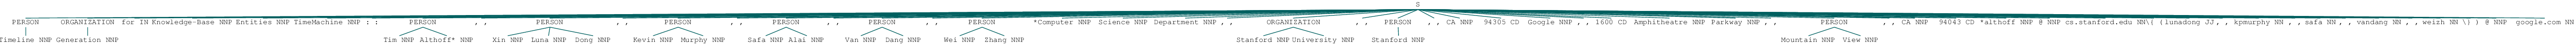

In [162]:
nltkstandard_top_entities_p19

In [ ]:
persons, organizations, locations

In [251]:
news = "Iran\’s supreme leader warned Sunday that Saudi Arabia would face divine vengeance for the execution of an outspoken Shiite cleric, a day after Iranian protesters ransacked the Saudi Embassy in Tehran in outrage over the execution.\“God\’s hand of retaliation will grip the neck of Saudi politicians,” said the supreme leader, Ayatollah Ali Khamenei, in comments reported on his official website.  Despite the rhetoric, however, the Iranians seemed to be taking steps to prevent the dispute from escalating further. Forty Iranians were arrested on Saturday night for the violence — a sign that the authorities were trying to keep public outrage from getting out of control.Iran\’s president, Hassan Rouhani, on Sunday condemned the execution, but also said that the attacks on the Saudi embassy in Tehran and the Saudi consulate in Mashhad had damaged Iran’s reputation.Firefighters battled a blaze at the Saudi Embassy in Tehran on Saturday after Iranian protesters entered the building.Iranian Protesters Ransack Saudi Embassy After Execution of Shiite ClericJAN. 2, 2016\“We do not allow rogue groups to commit illegal actions and damage the holy reputation of Islamic Republic of Iran,\” he said in a statement. \“What happened last night in Mashhad and Tehran and collateral damages in Saudi consulate and Embassy is not acceptable and justifiable.\”"

In [252]:
news

'Iran\\\xe2\x80\x99s supreme leader warned Sunday that Saudi Arabia would face divine vengeance for the execution of an outspoken Shiite cleric, a day after Iranian protesters ransacked the Saudi Embassy in Tehran in outrage over the execution.\\\xe2\x80\x9cGod\\\xe2\x80\x99s hand of retaliation will grip the neck of Saudi politicians,\xe2\x80\x9d said the supreme leader, Ayatollah Ali Khamenei, in comments reported on his official website.  Despite the rhetoric, however, the Iranians seemed to be taking steps to prevent the dispute from escalating further. Forty Iranians were arrested on Saturday night for the violence \xe2\x80\x94 a sign that the authorities were trying to keep public outrage from getting out of control.Iran\\\xe2\x80\x99s president, Hassan Rouhani, on Sunday condemned the execution, but also said that the attacks on the Saudi embassy in Tehran and the Saudi consulate in Mashhad had damaged Iran\xe2\x80\x99s reputation.Firefighters battled a blaze at the Saudi Embass

In [254]:
unicodedata.normalize('NFKD', news)

TypeError: must be unicode, not str

In [255]:
filter(lambda x: x in string.printable,unicodedata.normalize('NFKD', (unicode(news,errors='ignore'))).encode('ascii','ignore').decode('unicode_escape').encode('ascii','ignore'))

UnicodeDecodeError: 'unicodeescape' codec can't decode byte 0x5c in position 1343: \ at end of string

In [257]:
newsent = nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize((news.decode('unicode_escape').encode('ascii','ignore')))))

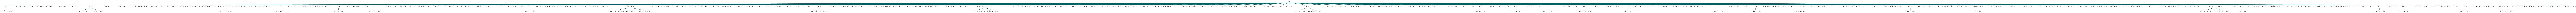

In [258]:
newsent

In [259]:
nltk.chunk.api.ChunkParserI(nltk.pos_tag(nltk.word_tokenize((news.decode('unicode_escape').encode('ascii','ignore')))))

TypeError: object() takes no parameters

In [260]:
nltk.chunk.api.ChunkParserI

In [275]:
chiefs = nltk.corpus.PlaintextCorpusReader(chiefpath, 'KCChiefs')

In [276]:
chiefs.fileids()

['KCChiefs']

In [278]:
raw = chiefs.raw('KCChiefs').decode('unicode_escape').encode('ascii','ignore')

In [ ]:
print nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(raw)))

In [284]:
raw ='This post was originally titled, "Should we root for the Chiefs to lose?", and was written when our Kansas City Chiefs were 3-5.\n\nThat may seem like an eternity ago, but there was a general sense during the week before the Chiefs played the Broncos in Denver that the season was lost. The focus here at Arrowhead Pride went quickly from the Super Bowl to mock drafts. Arguments that the Chiefs just tank the season for a better draft pick were seriously made. It seemed like a waste to even win two straight if it meant improving to a still-worthless 3-5.\n\nAfter all, the Andy Reid era Chiefs had never beaten Denver. And, even if they did, what were they supposed to do, go on a nine-game win streak and make the playoffs?\n\nStill, even within that atmosphere of capitulation as the Chiefs headed into their Week 9 bye to prepare for a trip to Denver, no one wanted them to lose that game. With the hated enemies one Sunday away, publishing a post asking for patience and a little faith in our 2015 Kansas City Chiefs seemed silly. AP was unanimous about going 1- 0, even if that meant only for one week. We could get back to rooting for the Chiefs to go 4-12 next week.\n\nI wrote an article prior to the Denver game saying the Chiefs are a better team than Denver and could beat them on the road. It ended with talk of the season\'s rough start and provided optimism moving forward:\n\nBut that should make winning all the more awesome when it happens, right? And the Chiefs are very, very close to winning. This is a good team finally on the right side of an unfortunate first half of football.\n\nSo I tucked away this post you\'re about to read. And I waited. And waited. And kept on waiting. The Chiefs kept on winning. And the Chiefs kept on winning some more. They kept on winning until this post, written near the nadir of 2015, was suddenly arguing for a perspective that everyone had since acquired.\n\nBut now Week 17 is upon us, and Kansas City is guaranteed at least two more games. The game will occur in Denver, Colorado at 5:30 pm.  This post could wait no longer. Take it as a reminder of how far our Chiefs have come since Week 9.\n\nI present, unedited from its original text, an argument for why we should stop calling for Andy Reid\'s head.\n'